In [1]:
# import packages
import pandas as pd
pd.set_option("display.precision", 2)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pylab import *
sns.set()

In [3]:
# read summary data
df_summary_CTB_plus = pd.read_csv('../data/tox21-data/class_info_adapted_+CTB.csv')
df_summary_CTB_minus = pd.read_csv('../data/tox21-data/class_info_adapted2_-CTB.csv')
df_summary_CTB_plus["cytotox"] = "yes"
df_summary_CTB_minus["cytotox"] = "no"
df_summary_CTB = pd.concat([df_summary_CTB_plus, df_summary_CTB_minus])
total = df_summary_CTB.isnull().sum().sort_values(ascending=False)
percent = (df_summary_CTB.isnull().sum()/df_summary_CTB.isnull().count()
           ).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(df_summary_CTB.head())
print(df_summary_CTB.shape)
# cp class_info_adapted_+CTB.csv ../data/used

    class_id  sum_hitc  count_hitc  unique_aeid  \
0   class_14        89       23305            3   
1  class_143        13         826            1   
2   class_16        77        9143           14   
3  class_176        86         726            1   
4  class_179       113        3133            2   

                                         unique_aenm  unique_DTXSID  perc_hit  \
0  TOX21_SBE_BLA_Antagonist_ch2, TOX21_SBE_BLA_An...           6720      0.38   
1                                      NVS_GPCR_rTRH            824      1.57   
2  TOX21_PXR_Agonist, TOX21_TRA_COA_Agonist_Follo...           6644      0.84   
3                                      NVS_NR_hPPARg            633     11.85   
4  UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Agonist, UPITT...           1567      3.61   

  cytotox  
0     yes  
1     yes  
2     yes  
3     yes  
4     yes  
(858, 8)


In [4]:
# advanced exploratory data
df = df_summary_CTB
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
# del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: 



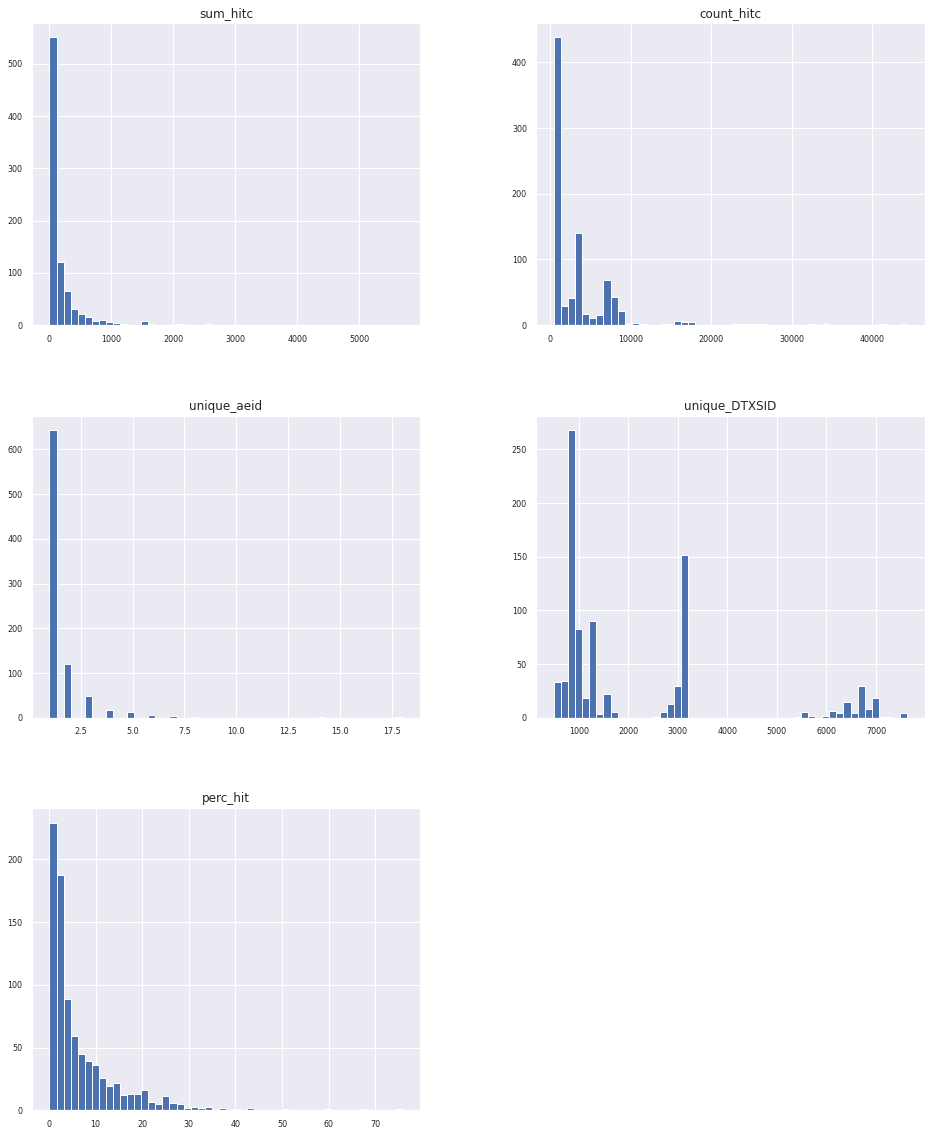

In [5]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [6]:
df_num_corr = df_num.corr()['lots_of_chemicals'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with lots_of_chemicals:\n{}".format(len(golden_features_list), golden_features_list))

KeyError: 'lots_of_chemicals'

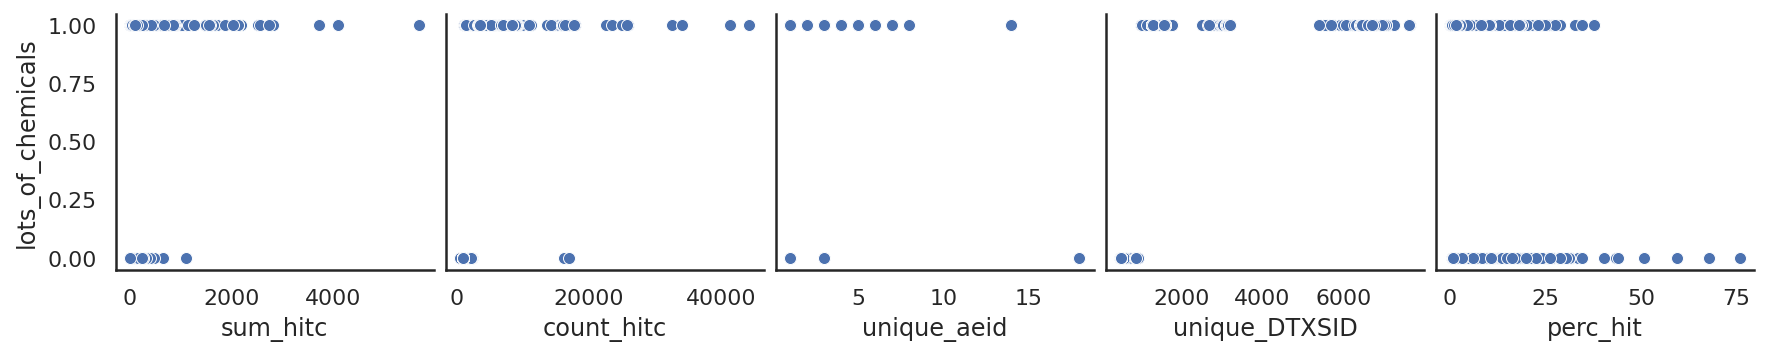

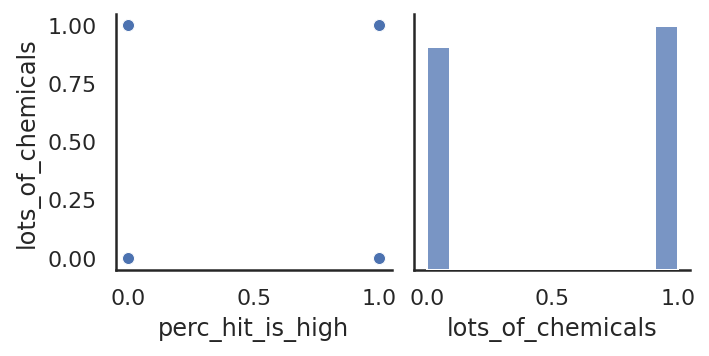

In [90]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['lots_of_chemicals'])

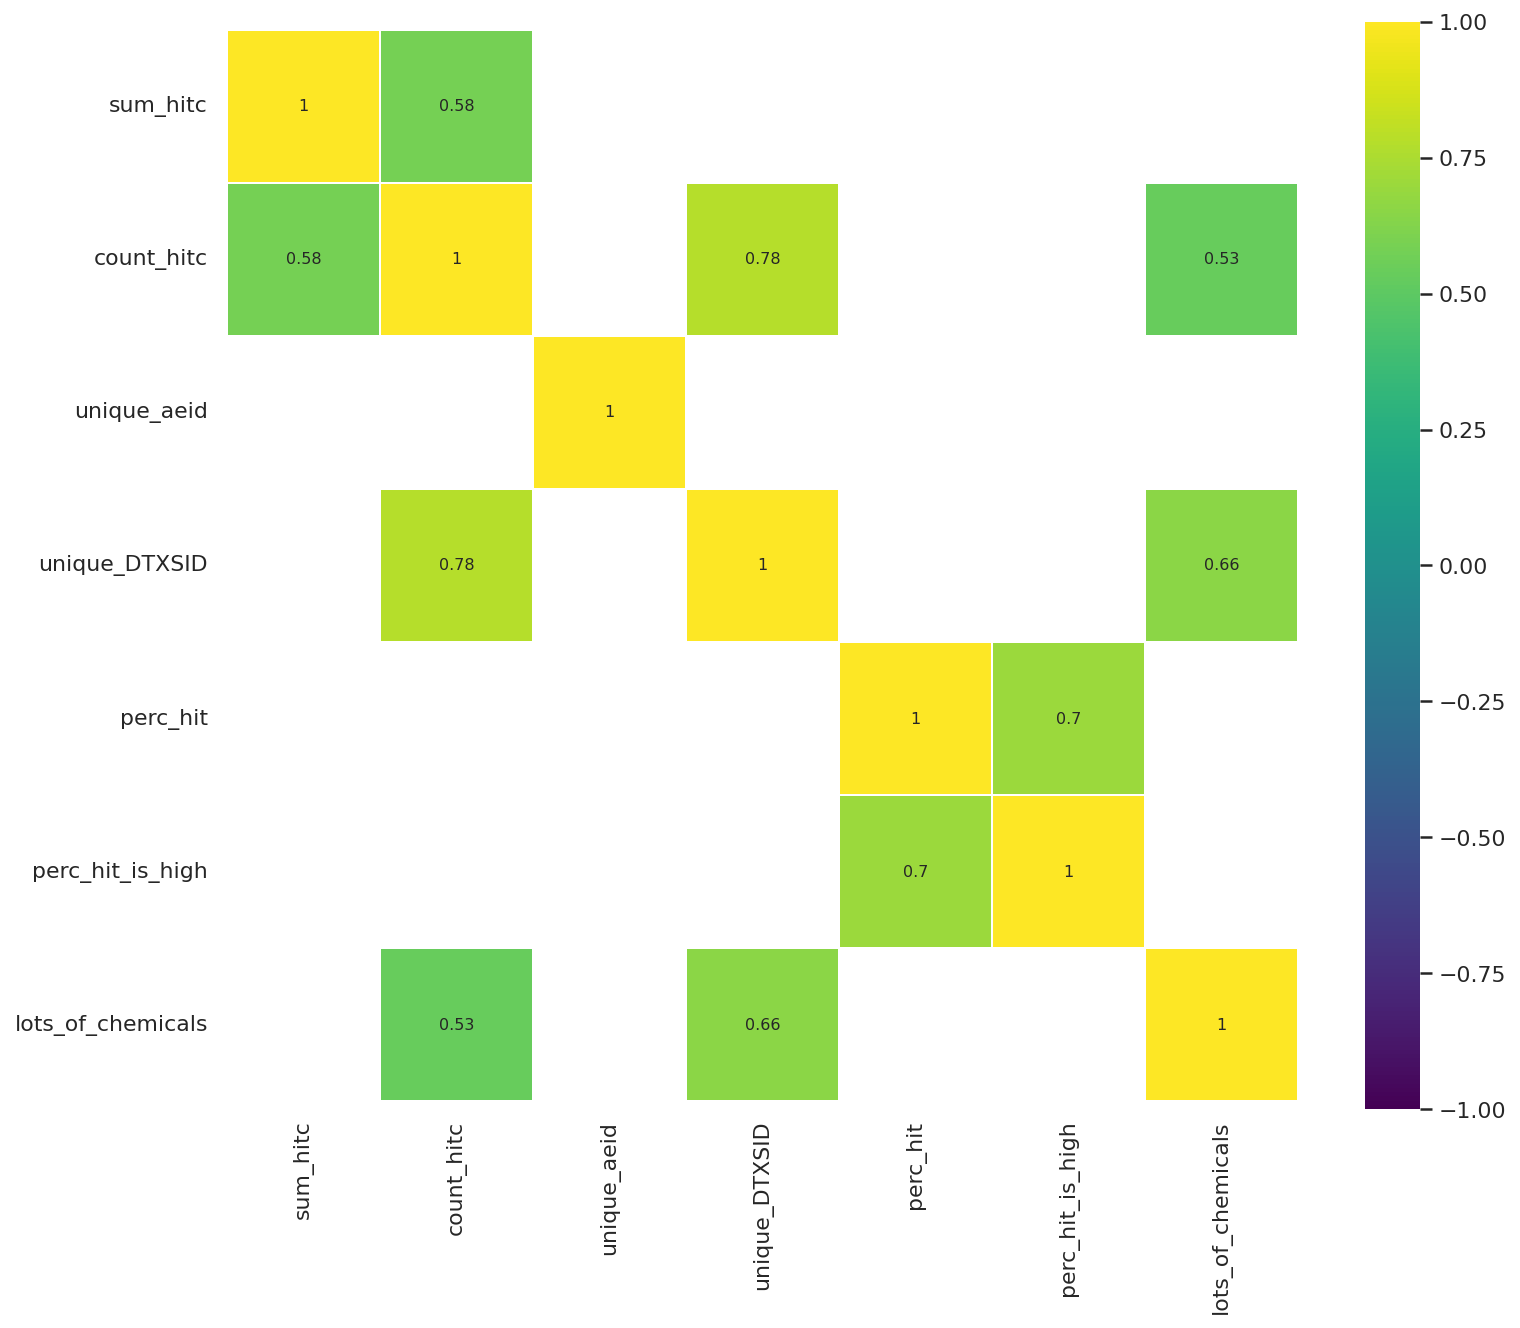

In [93]:
corr = df_num.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [94]:
quantitative_features_list = ["sum_hitc", "count_hitc", "unique_aeid", "unique_DTXSID", "perc_hit"]
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

,sum_hitc,count_hitc,unique_aeid,unique_DTXSID,perc_hit
0,89,23305,3,6720,0.38
1,13,826,1,824,1.57
2,77,9143,14,6644,0.84
3,86,726,1,633,11.85
4,113,3133,2,1567,3.61


In [97]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse.append('perc_hit_is_high')
features_to_analyse

['count_hitc', 'unique_DTXSID', 'perc_hit_is_high']

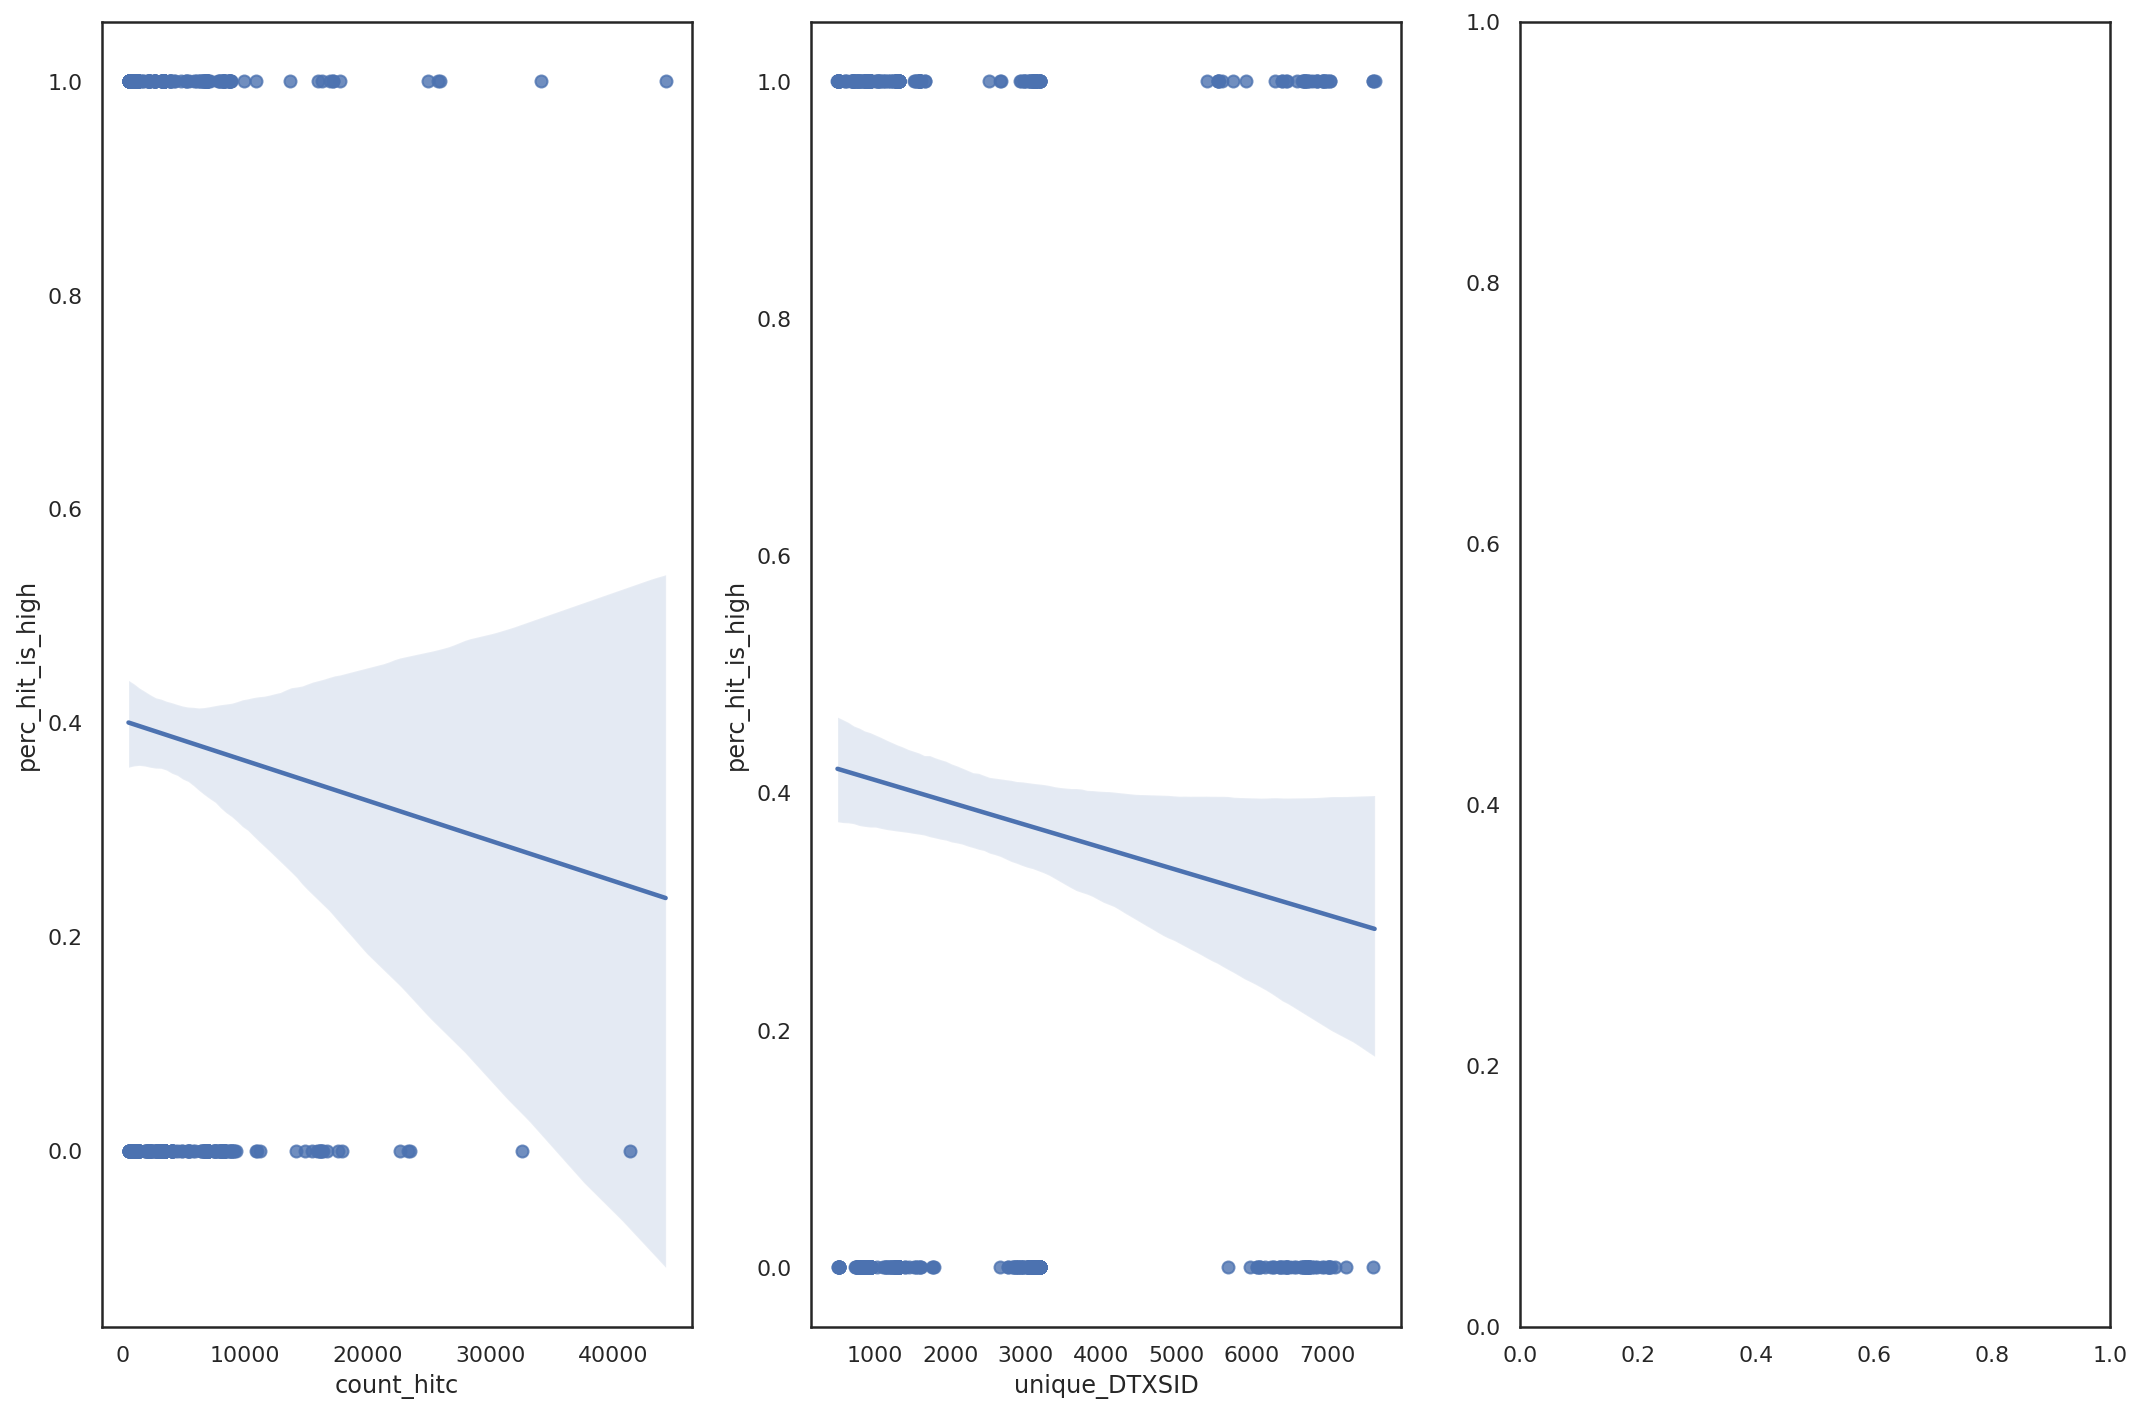

In [99]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='perc_hit_is_high', data=df[features_to_analyse], ax=ax)

In [100]:
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.head()

,class_id,unique_aenm,perc_hit,cytotox,perc_hit_is_high,lots_of_chemicals
0,class_14,"TOX21_SBE_BLA_Antagonist_ch2, TOX21_SBE_BLA_An...",0.38,yes,0,1
1,class_143,NVS_GPCR_rTRH,1.57,yes,0,0
2,class_16,"TOX21_PXR_Agonist, TOX21_TRA_COA_Agonist_Follo...",0.84,yes,0,1
3,class_176,NVS_NR_hPPARg,11.85,yes,1,0
4,class_179,"UPITT_HCI_U2OS_AR_TIF2_Nucleoli_Agonist, UPITT...",3.61,yes,0,1


In [101]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 3 non numerical features including:
['class_id', 'unique_aenm', 'cytotox']


(array([0, 1]), [Text(0, 0, 'yes'), Text(1, 0, 'no')])

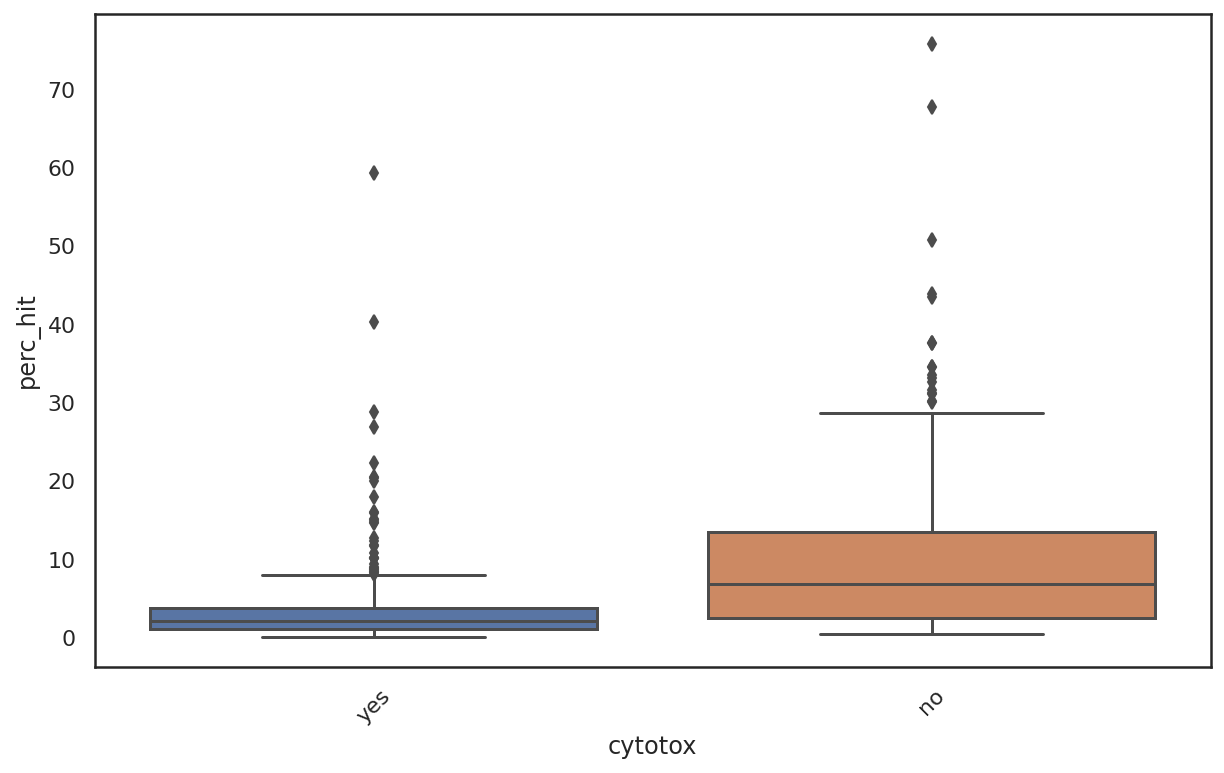

In [105]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='cytotox', y='perc_hit', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [ ]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()